<a href="https://colab.research.google.com/github/arfafax/StyleGAN2_experiments/blob/master/TFDNE_Editor_v1_TF_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Fursona Does Not Exist - Fursona Editor (Tensorflow Version)

For a faster, easier to use editor (albeit with fewer customization options), try [Artbreeder](https://artbreeder.com) and select a furry image to start customizing.

### To run:
**Click "Open in Playground" above (if you see that option) and then Runtime > Run All and wait a few minutes for everything to load. (Takes about 4 minutes)**

Feel free to watch the demo video or read the code (by clicking the triangle in the next section) while you wait.

---


### Credits

Customizable furries using [@arfa](https://twitter.com/arfafax)'s furry StyleGAN2 model from [TFDNE](https://thisfursonadoesnotexist.com/).

Latent directions were discovered using [@harskish](https://twitter.com/harskish)'s [Ganspace](https://github.com/harskish/ganspace) [notebook](https://colab.research.google.com/github/harskish/ganspace/blob/master/notebooks/Ganspace_colab.ipynb) put together by [@realmeatyhuman](https://twitter.com/realmeatyhuman), with help from [@KeyKitsune](https://twitter.com/KitsuneKey) for providing code to load the saved latent directions.



---



### Shameless Plug
If you enjoyed This Fursona Does Not Exist and want to see more projects like it in the future, consider supporting me on Ko-fi or Patreon.

-arfa


<div>
<a href="https://www.twitter.com/arfafax">
<img src="https://thisfursonadoesnotexist.com/arfa_sig.png" width="350"/>
</a>
</div>
<div>
<a href="https://ko-fi.com/arfafax">
<img src="https://cdn.ko-fi.com/cdn/kofi3.png?v=2" width="220"/>
</a>
<a href="https://www.patreon.com/arfafax">
<img src="https://c5.patreon.com/external/logo/become_a_patron_button.png" width="235"/>
</a>
</div>




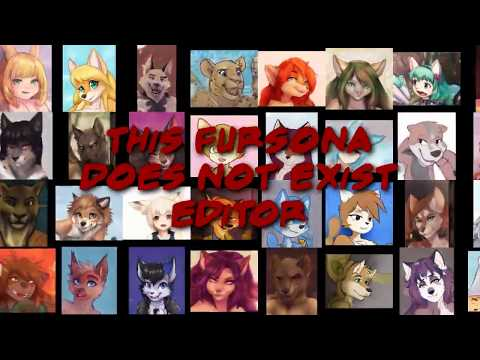

In [ ]:
#@title Demo video
from IPython.display import YouTubeVideo
YouTubeVideo('dyV_URuA0yE', width=1280, height=720)

## <- Click the triangle to view the code while you wait for it to load


In [ ]:
!git clone https://github.com/shawwn/stylegan2 -b estimator /content/stylegan2

Cloning into '/content/stylegan2'...
remote: Enumerating objects: 1297, done.
remote: Total 1297 (delta 0), reused 0 (delta 0), pack-reused 1297
Receiving objects: 100% (1297/1297), 883.40 KiB | 6.54 MiB/s, done.
Resolving deltas: 100% (924/924), done.


In [ ]:
import gdown
!wget  -O /content/network-e621.pkl https://thisfursonadoesnotexist.com/model/network-e621-r-512-3194880.pkl
!wget  -O /content/directions.zip https://thisfursonadoesnotexist.com/directions.zip

--2020-06-11 03:22:46--  https://thisfursonadoesnotexist.com/model/network-e621-r-512-3194880.pkl
Resolving thisfursonadoesnotexist.com (thisfursonadoesnotexist.com)... 104.27.185.7, 104.27.184.7, 172.67.221.180, ...
Connecting to thisfursonadoesnotexist.com (thisfursonadoesnotexist.com)|104.27.185.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364035409 (347M) [application/octet-stream]
Saving to: ‘/content/network-e621.pkl’

/content/network-e6 100%[===================>] 347.17M  9.93MB/s    in 36s     

2020-06-11 03:23:22 (9.76 MB/s) - ‘/content/network-e621.pkl’ saved [364035409/364035409]

--2020-06-11 03:23:22--  https://thisfursonadoesnotexist.com/directions.zip
Resolving thisfursonadoesnotexist.com (thisfursonadoesnotexist.com)... 104.27.185.7, 104.27.184.7, 172.67.221.180, ...
Connecting to thisfursonadoesnotexist.com (thisfursonadoesnotexist.com)|104.27.185.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155267 (152K) 

In [ ]:
%tensorflow_version 1.x
%cd /content/stylegan2

TensorFlow 1.x selected.
/content/stylegan2


In [ ]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import scipy
import tensorflow as tf
import tflex



attach_debugger <function attach_debugger at 0x7f694d474ea0>
print_status <function print_status at 0x7f694d474f28>
freeze_forever <function freeze_forever at 0x7f694d475048>
quit <function quit at 0x7f694d4750d0>
save_and_quit <function save_and_quit at 0x7f694d4751e0>
throw_exception <function throw_exception at 0x7f694d475268>


In [ ]:
if 'COLAB_TPU_ADDR' in os.environ:
    os.environ['TPU_NAME'] = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    os.environ['NOISY'] = '1'

In [ ]:
tflib.init_tf()
sess = tf.get_default_session()
sess.list_devices()
cores = tflex.get_cores()
tflex.set_override_cores(cores)
_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

In [ ]:
 def generate_image_from_w(w, truncation_psi):
    with tflex.device('/gpu:0'):
        #_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
        noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
        Gs_kwargs = dnnlib.EasyDict()
        Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        Gs_kwargs.randomize_noise = False
        if truncation_psi is not None:
            Gs_kwargs.truncation_psi = truncation_psi
        synthesis_kwargs = dict(output_transform=Gs_kwargs.output_transform, truncation_psi=truncation_psi, minibatch_size=1)
        images = Gs.components.synthesis.run(w, randomize_noise=False, **synthesis_kwargs)
        #PIL.Image.fromarray(images[0], 'RGB').save('seed%04d.png' % seed)
        display(PIL.Image.fromarray(images[0], 'RGB'))

In [ ]:
%cd "/content"

/content


In [ ]:
!unzip /content/directions.zip

Archive:  /content/directions.zip
   creating: directions/.ipynb_checkpoints/
  inflating: directions/eye_size_layers_5_9.npy  
  inflating: directions/squint_layers_8_9.npy  
  inflating: directions/lighting_layers_10_12.npy  
  inflating: directions/smile_2_layers_8_9.npy  
  inflating: directions/colors_6_layers_8_16.npy  
  inflating: directions/colors_layers_8_16.npy  
  inflating: directions/colors_4_layers_11_16.npy  
  inflating: directions/head_forward_layers_2_5.npy  
  inflating: directions/head_turn_layers_2_4.npy  
  inflating: directions/colors_5_layers_8_16.npy  
  inflating: directions/roll_layers_2_10.npy  
  inflating: directions/head_tilt_layers_0_4.npy  
  inflating: directions/style_layers_7_11.npy  
  inflating: directions/background_darkness_layers_10_11.npy  
  inflating: directions/head_size_layers_4_6.npy  
  inflating: directions/head_tilt_layers_0_3.npy  
  inflating: directions/hair_color_layers_7_16.npy  
  inflating: directions/zoom_layers_0_5.npy  
  inf

In [ ]:
!rm /content/directions/StyleGAN2-Light_direction-ffhq-ipca-w-style-comp15-range8-9.pkl
!rm -r /content/directions/.ipynb_checkpoints
#!mv /content/directions/directions/* /content/ganspace/directions
!rm -r /content/directions/directions

In [ ]:
import os
named_directions = {}
latent_dirs = []
starts = []
ends = []
# 
path_to_directions = "/content/directions"

# This loads the directions in a dictionary in this format:
# {'name' : [direction_num, start, end]}
# and you load the direction by:
# directions[direction_num]

for i,file in enumerate(sorted(os.listdir(path_to_directions))):
    np_file = np.load(f'{path_to_directions}/{file}', allow_pickle=True)
    name = file.split("_layers_")[0].split("/")[-1]
    file = file.split('_')
    
    named_directions[f'{name}'] = [i, int(file[-2]), int(file[-1].split('.')[0])]
    latent_dirs.append(np_file)


In [ ]:
named_directions

{'anime': [0, 6, 11],
 'aspect_ratio': [2, 0, 5],
 'background_color': [3, 10, 11],
 'background_darkness': [4, 10, 11],
 'color_3': [5, 10, 16],
 'colors': [11, 8, 16],
 'colors_2': [6, 9, 16],
 'colors_4': [7, 11, 16],
 'colors_5': [8, 8, 16],
 'colors_6': [9, 8, 16],
 'eye_direction': [12, 6, 8],
 'eye_shape': [13, 7, 8],
 'eye_size': [14, 5, 9],
 'fatness': [15, 4, 7],
 'fur_darkness': [16, 10, 16],
 'fur_detail': [17, 8, 10],
 'fur_pattern': [18, 9, 16],
 'hair': [23, 4, 7],
 'hair_color': [20, 7, 16],
 'hair_color_2': [19, 11, 13],
 'hair_darkness': [21, 10, 12],
 'head_forward': [24, 2, 5],
 'head_size': [25, 4, 6],
 'head_t': [26, 0, 4],
 'head_tilt': [28, 0, 4],
 'head_turn': [31, 3, 4],
 'head_turn_2': [29, 2, 4],
 'lighting': [32, 10, 12],
 'mouth_open': [34, 8, 9],
 'mouth_open_2': [33, 7, 10],
 'muzzle_length': [36, 5, 7],
 'roll': [37, 2, 10],
 'shading': [38, 10, 14],
 'simplify': [39, 4, 10],
 'smile': [41, 8, 9],
 'smile_2': [40, 8, 9],
 'squint': [42, 8, 9],
 'style':

# UI

In [ ]:
#@title Run UI (make sure you've done Runtime > Run All first or it won't work)
from ipywidgets import fixed
import PIL
import numpy as np
import ipywidgets as widgets
from PIL import Image
from IPython.display import clear_output

def display_sample(seed, truncation, direction, distance, scale, start, end, update, disp=True, save=None, noise_spec=None, **args):
    if update == False:
        print("False")
    # blockPrint()
    rng = np.random.RandomState(seed)
    z = rng.standard_normal(*Gs.input_shape[1:]).reshape(1, *Gs.input_shape[1:])

    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.randomize_noise = False

    all_w = Gs.components.mapping.run(z, None, **Gs_kwargs) # [minibatch, layer, component]

    for i, item in enumerate(args):
        value = args[item]
        start_l = named_directions[item][1]
        end_l = named_directions[item][2]
        direction_l = latent_dirs[named_directions[item][0]]
        for l in range(start_l, end_l):
            all_w[0][l] = all_w[0][l] + direction_l * value * scale

    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]

    generate_image_from_w(all_w, truncation)

seed = np.random.randint(0,100000)
style = {'description_width': '110px'}
row_length = 5

seed = widgets.IntSlider(min=0, max=100000, step=1, value=seed, description='Seed: ', continuous_update=False)
truncation = widgets.FloatSlider(min=0, max=2, step=0.1, value=0.4, description='Truncation: ', continuous_update=False)
distance = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description='Distance: ', continuous_update=False, style=style)
scale = widgets.FloatSlider(min=0, max=10, step=0.05, value=1, description='Scale: ', continuous_update=False)
start_layer = widgets.IntSlider(min=0, max=18, step=1, value=18, description='start layer: ', continuous_update=False)
end_layer = widgets.IntSlider(min=0, max=18, step=1, value=18, description='end layer: ', continuous_update=False)


update = widgets.Checkbox(value=True, description="update")

directions_list = []
params = {'seed': seed, 'truncation': truncation, 'direction': fixed(0), 'distance': distance, 'scale': scale, 'start': start_layer, 'end': end_layer, 'update' : update}

for i, item in enumerate(named_directions):
    widget = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description=item + ': ', continuous_update=False, style=style, layout={'width' : '350px'})
    directions_list.append(widget)
    params[item] = widget

bot_box = widgets.HBox([seed, truncation])

ui = widgets.VBox([bot_box])

row_list = []
foo = []
for i, item in enumerate(directions_list):
    row_list.append(item)
    if len(row_list) == row_length:
        bar = widgets.HBox(row_list)
        foo.append(bar)
        row_list = []
bar = widgets.HBox(row_list)
foo.append(bar)

ui2 = widgets.VBox(foo)

random = widgets.Button(description="Randomize Sliders")
reset = widgets.Button(description="Reset Sliders")
mobile = widgets.Button(description="Mobile Mode")
desktop = widgets.Button(description="Desktop Mode")
def reset_sliders(b):
    directions_list = []
    params_new = {'seed': seed, 'truncation': truncation, 'direction': fixed(0), 'distance': distance, 'scale': scale, 'start': start_layer, 'end': end_layer, 'update' : update}
    for i, item in enumerate(named_directions):
        widget = widgets.FloatSlider(min=-20, max=20, step=0.1, value=0, description=item + ': ', continuous_update=False, style=style, layout={'width' : '350px'})
        directions_list.append(widget)
        params_new[item] = widget
    params = params_new
    row_list = []
    foo = []
    for i, item in enumerate(directions_list):
        row_list.append(item)
        if len(row_list) == row_length:
            bar = widgets.HBox(row_list)
            foo.append(bar)
            row_list = []
    bar = widgets.HBox(row_list)
    foo.append(bar)

    ui2 = widgets.VBox(foo)
    clear_output()
    out = widgets.interactive_output(display_sample, params)
    last_button = mobile
    if row_length == 1:
        last_button = desktop
    display(ui, out, ui2, reset, random, last_button)

def random_sliders(b):
    directions_list = []
    params_new = {'seed': seed, 'truncation': truncation, 'direction': fixed(0), 'distance': distance, 'scale': scale, 'start': start_layer, 'end': end_layer, 'update' : update}
    for i, item in enumerate(named_directions):
        widget = widgets.FloatSlider(min=-20, max=20, step=0.1, value=np.random.normal(scale=2.5), description=item + ': ', continuous_update=False, style=style, layout={'width' : '350px'})
        directions_list.append(widget)
        params_new[item] = widget
    params = params_new
    row_list = []
    foo = []
    for i, item in enumerate(directions_list):
        row_list.append(item)
        if len(row_list) == row_length:
            bar = widgets.HBox(row_list)
            foo.append(bar)
            row_list = []
    bar = widgets.HBox(row_list)
    foo.append(bar)

    ui2 = widgets.VBox(foo)
    clear_output()
    out = widgets.interactive_output(display_sample, params)
    last_button = mobile
    if row_length == 1:
        last_button = desktop
    display(ui, out, ui2, reset, random, last_button)

def mobile_mode(b):
    global row_length
    global params
    row_length = 1
    directions_list = []
    params_new = {'seed': seed, 'truncation': truncation, 'direction': fixed(0), 'distance': distance, 'scale': scale, 'start': start_layer, 'end': end_layer, 'update' : update}
    for i, item in enumerate(named_directions):
        widget = widgets.FloatSlider(min=-20, max=20, step=0.1, value=params[item].value, description=item + ': ', continuous_update=False, style=style, layout={'width' : '350px'})
        directions_list.append(widget)
        params_new[item] = widget
    params = params_new
    row_list = []
    foo = []
    for i, item in enumerate(directions_list):
        row_list.append(item)
        if len(row_list) == row_length:
            bar = widgets.HBox(row_list)
            foo.append(bar)
            row_list = []
    bar = widgets.HBox(row_list)
    foo.append(bar)

    ui2 = widgets.VBox(foo)
    clear_output()
    out = widgets.interactive_output(display_sample, params)
    display(ui, out, ui2, reset, random, desktop)

def desktop_mode(b):
    global row_length
    global params
    row_length = 5
    directions_list = []
    params_new = {'seed': seed, 'truncation': truncation, 'direction': fixed(0), 'distance': distance, 'scale': scale, 'start': start_layer, 'end': end_layer, 'update' : update}
    for i, item in enumerate(named_directions):
        widget = widgets.FloatSlider(min=-20, max=20, step=0.1, value=params[item].value, description=item + ': ', continuous_update=False, style=style, layout={'width' : '350px'})
        directions_list.append(widget)
        params_new[item] = widget
    params = params_new
    row_list = []
    foo = []
    for i, item in enumerate(directions_list):
        row_list.append(item)
        if len(row_list) == row_length:
            bar = widgets.HBox(row_list)
            foo.append(bar)
            row_list = []
    bar = widgets.HBox(row_list)
    foo.append(bar)

    ui2 = widgets.VBox(foo)
    clear_output()
    out = widgets.interactive_output(display_sample, params)
    display(ui, out, ui2, reset, random, mobile)

random.on_click(random_sliders)
reset.on_click(reset_sliders)
mobile.on_click(mobile_mode)
desktop.on_click(desktop_mode)
out = widgets.interactive_output(display_sample, params)

display(ui, out, ui2, reset, random, mobile)


Output()

Button(description='Reset Sliders', style=ButtonStyle())

Button(description='Randomize Sliders', style=ButtonStyle())

Button(description='Mobile Mode', style=ButtonStyle())